In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [49]:
# neural network layer
class layer:
    
    # initialization (weights and biases)
    def __init__(self,n_inputs, n_neurons): # self represents the instance of the class
        self.weights = 0.1*np.random.randn(n_inputs,n_neurons) # small random numbers
        self.biases = np.zeros((1,n_neurons))# zeros
        
        # initialize momentums and caches
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
    # forward pass: pass the data through the layer
    def forward(self, inputs):
        # we need to store the output
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)
        
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        

        
# activation function
class ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):

        # copy dvalues
        self.dinputs = dinputs.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
        

        
# softmax activation function
class softmax:
    
    def forward(self, inputs):
        
        # unnormalized probabilities
        exp_values = np.exp(inputs)
        
        # normalized probabilities
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
        # remember input values
        self.inputs = inputs
        
    def backward(self,dinputs):

        
        # initialized gradient array
        self.dinputs = np.zeros(dinputs.shape)
        
        # For each data point, compute gradient
        for i in range(len(dinputs)):
            
            # probabilities 
            proba = self.output[i]
            
            # loss gradients
            dinputs_row = dinputs[i]


            # calculate derivative matrix of the output
            derivative_matrix = np.diag(proba) - proba.reshape(-1,1).dot(proba.reshape(1,-1))
            
            # store gradient
            self.dinputs[i] = dinputs_row.dot(derivative_matrix)
            

class loss_crossentropy():
    
    def forward(self, y_hat, y):
        
        # number of data points
        n_samples = len(y)
        
        # clip data to prevent division by 0
        y_hat_clipped = np.clip(y_hat, 1e-7,1 - 1e-7)
        
        # predicted class probabilities
        pred_proba = y_hat_clipped[range(n_samples),y]
       
        # sample losses 
        losses = -np.log(pred_proba)
        
        return losses
    
    
    def backward(self, p, y):
        
        
        # number of samples
        n_samples = len(y)
    
        # one-hot matrix
        Y = np.zeros(p.shape)
        Y[np.arange(len(y)),y] = 1
        
        # calculate gradient
        self.dinputs = -Y / p
        
        # normalized gradient
        self.dinputs = self.dinputs / n_samples
            
            
        
class optimizer_GD:

    def __init__(self, learning_rate=1):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        
        # apply gradient descent iteration
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases
        
        
# Adam optimizer
class optimizer_ADAM:
    
    # Initialize optimizer - set parameters
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,beta_1=0.9, beta_2=0.999):
        
        # initial learning rate
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        
        # decay parameters
        self.decay = decay
        
        # number of epochs
        self.epoch = 0
        
        # update learning rate parameter
        self.epsilon = epsilon
        
        # momentum parameter
        self.beta_1 = beta_1
        
        # cache parameter
        self.beta_2 = beta_2
        
        
    # update learning rate
    def pre_update_parameters(self):
        
        # update learning rate
        self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.epoch))
            
    # Update weights/biases
    def update_parameters(self, layer):
                   
        # momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # corrected momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        
        # cache
        layer.weight_caches = self.beta_2 * layer.weight_caches + (1 - self.beta_2) * layer.dweights**2  
        layer.bias_caches = self.beta_2 * layer.bias_caches + (1 - self.beta_2) * layer.dbiases**2
        
        # corrected cache
        weight_caches_corrected = layer.weight_caches / (1 - self.beta_2 ** (self.epoch + 1))
        bias_caches_corrected = layer.bias_caches / (1 - self.beta_2 ** (self.epoch + 1))
        
        # update weights and biases
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_caches_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_caches_corrected) + self.epsilon)
        
    # update epoch
    def post_update_parameters(self):
        self.epoch += 1
        
        
# dropout layer
class dropout:
    
    # initialization - set the dropout rate
    def __init__(self, rate):
        self.rate = rate
        
    # forward pass
    def forward(self, inputs):
        # save inputs 
        self.inputs = inputs
        # mask
        self.mask = np.random.binomial(1, 1 - self.rate, size = inputs.shape) / (1 - self.rate)
        # apply mask
        self.output = inputs * self.mask
        
    # backward pass
    def backward(self, dinputs):
        self.dinputs = dinputs*self.mask
        

In [4]:
# dropout example
X = np.random.randn(10,3)
X

array([[-0.70084869, -0.32984579, -0.23038424],
       [-0.26082863,  0.38495273, -0.11490086],
       [ 1.01592788,  1.72523344, -0.33997112],
       [-0.43487781,  2.63157315, -0.64094365],
       [-1.00116569,  0.27603469, -1.43453292],
       [ 1.61811186, -1.02894111,  0.24438454],
       [-1.78930234, -0.1617099 , -1.01352952],
       [ 1.03250714,  1.50465947, -1.01066978],
       [-1.08727267, -1.45160264,  2.4574214 ],
       [-1.36555222,  1.21767386,  1.41412446]])

In [40]:
# dropout rate
rate = 0.8 # drop 30% of the neurons

In [41]:
#  randomly sets input units to 0
mask = np.random.binomial(1, 1-rate, size = X.shape)
mask

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 1, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 0]])

In [42]:
# inputs not set to zero are scaled up by 1/(1-rate)
mask*X/(1-rate)

array([[-0.        , -0.        , -0.        ],
       [-0.        ,  1.92476363, -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [-0.        , 13.15786573, -0.        ],
       [-0.        ,  0.        , -0.        ],
       [ 0.        , -0.        ,  0.        ],
       [-0.        , -0.        , -0.        ],
       [ 5.16253572,  0.        , -0.        ],
       [-0.        , -7.2580132 ,  0.        ],
       [-0.        ,  0.        ,  0.        ]])

In [43]:
np.sum(np.abs(X))

29.91948420222979

In [44]:
np.sum(np.abs(mask*X))

5.500635657038425

In [45]:
np.sum(np.abs(mask*X/(1-rate)))

27.503178285192135

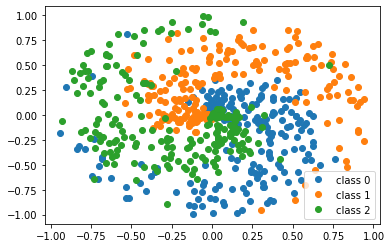

In [46]:
# generate toy dataset
classes = 3
n_points = 200
noise = 0.7
radius = 4

X = np.zeros((n_points*classes, 2))
y = np.zeros(n_points*classes).astype('int')

for class_number in range(classes):
    ix = range(n_points*class_number, n_points*(class_number+1))
    r = np.linspace(0,1, n_points)
    t = np.linspace(class_number*radius, (class_number+1)*radius, n_points) + np.random.randn(n_points)*noise
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = class_number
    
for i in range(classes):
    plt.plot(X[y==i,0],X[y==i,1],'o',label = 'class '+str(i))
plt.legend()

In [57]:
# build neural network

# layer 1
layer1 = layer(n_inputs = 2, n_neurons = 64)
activation1 = ReLU()
dropout1 = dropout(0.2)

# layer 2
layer2 = layer(n_inputs = 64, n_neurons = 64)
activation2 = ReLU() 
dropout2 = dropout(0.2)

# layer 3 
layer3 = layer(n_inputs = 64, n_neurons = classes)
activation3  = softmax()

# loss function 
loss_function = loss_crossentropy()

# optimizer
optimizer = optimizer_ADAM(learning_rate=0.05)

In [58]:
n_epochs = 1000
loss_adam = np.zeros(n_epochs)
accuracy_adam = np.zeros(n_epochs)
# gradient descent iterations
for epoch in range(n_epochs):

    # forward pass
    layer1.forward(X)
    activation1.forward(layer1.output)
    dropout1.forward(activation1.output)
    
    layer2.forward(dropout1.output)
    activation2.forward(layer2.output)
    dropout2.forward(activation2.output)
    
    layer3.forward(dropout2.output)
    activation3.forward(layer3.output)

    # loss (mean squared error)
    losses = loss_function.forward(activation3.output,y)
    loss_adam[epoch] = np.mean(losses)
    
    # accuracy
    y_pred = np.argmax(activation3.output,axis=1)
    accuracy_adam[epoch] = 100*np.mean(y_pred == y)

    # backward pass
    loss_function.backward(activation3.output,y)
    activation3.backward(loss_function.dinputs)
    layer3.backward(activation3.dinputs)
    
    dropout2.backward(layer3.dinputs)
    activation2.backward(dropout2.dinputs)
    layer2.backward(activation2.dinputs)
    
    dropout1.backward(layer2.dinputs)
    activation1.backward(dropout1.dinputs)
    layer1.backward(activation1.dinputs)
    
    
    # update weights and biases
    optimizer.pre_update_parameters()
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    optimizer.update_parameters(layer3)
    optimizer.post_update_parameters()

    
    
    # print loss and accuracy (every 100 epochs)
    if epoch % 100 == 0:
        # loss
        loss = np.round(np.mean(losses),3)
        # accuracy (percentage of correct classifications)
        y_pred = np.argmax(activation3.output,axis=1)
        accuracy = np.round(100*np.mean(y==y_pred),3)
        print('epoch: '+str(epoch))
        print('loss: '+str(np.round(loss_adam[epoch],3)))
        print('accuracy: '+str(accuracy_adam[epoch]))
        print('------------------------')

epoch: 0
loss: 1.098
accuracy: 31.666666666666664
------------------------
epoch: 100
loss: 0.367
accuracy: 84.66666666666667
------------------------
epoch: 200
loss: 0.351
accuracy: 85.66666666666667
------------------------
epoch: 300
loss: 0.337
accuracy: 86.5
------------------------
epoch: 400
loss: 0.327
accuracy: 85.83333333333333
------------------------
epoch: 500
loss: 0.304
accuracy: 86.66666666666667
------------------------
epoch: 600
loss: 0.331
accuracy: 85.5
------------------------
epoch: 700
loss: 0.314
accuracy: 88.33333333333333
------------------------
epoch: 800
loss: 0.309
accuracy: 86.33333333333333
------------------------
epoch: 900
loss: 0.34
accuracy: 85.16666666666667
------------------------


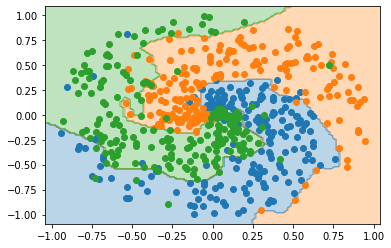

In [59]:
# plot classification regions
from matplotlib.colors import ListedColormap
# step size
h = 0.02

# mesh grid
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
X_plot = np.c_[xx.ravel(),yy.ravel()]

# forward pass
layer1.forward(X_plot)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)
layer3.forward(activation2.output)
activation3.forward(layer3.output)


# predictions
y_pred = activation3.output
y_plot = np.argmax(y_pred, axis=1)
y_plot = y_plot.reshape(xx.shape)

# classification regions
my_cmap = ListedColormap(['C'+str(i) for i in range(classes)])
plt.contourf(xx, yy, y_plot, cmap=my_cmap, alpha=0.3)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# dataset
for i in range(classes):
    plt.plot(X[y==i,0],X[y==i,1],'o')